## Find Closet Stable Pose using Brute Force Method
* This notebook provides an pipeline of how to find the closest stable pose $T_\text{part}^\text{tag}(x, y, z, \alpha, \beta, \gamma)$ to a given pose estimate $\widehat{T}_\text{part}^\text{tag}$. 
* Brute Force Method: Find the stable pose that is closest to the given estimate. The distance metric here is the **Augular Difference** between two orientation representaions.

<img src="./11_23_image_dataset/stable_pose_parametrization.jpg" width="800">

### 1 Example with make-up Estimate for Insert Mold
##### Step1: construct a list of stable poses(orientation) represented by Rotation matrices

In [67]:
from scipy.spatial.transform import Rotation
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# these two lists should be element-aligned. 
# i.e. alphas[i] should correspond to z_offsets[i]
alphas_insertmold = np.array([0, 12, -146, 156])
z_offsets_insertmold = np.array([0.0021, 0.0019, 0.0032, 0.0013])

def construct_R_sta_list(alphas):
    beta = 0
    # decretize gama at step of 1 degree
    gamas = np.arange(0, 360, 1)
    stable_poses_R = []
    for alpha in alphas:
        for gama in gamas:
            R = Rotation.from_euler('xyz', [alpha, beta, gama], degrees=True)
            stable_poses_R.append(R.as_matrix())
    return stable_poses_R

stable_poses_R = construct_R_sta_list(alphas_insertmold)
print("Number of stable poses to consider: ", len(stable_poses_R))

Number of stable poses to consider:  1440


##### Step2: Find the closest three stable poses by iteratively computing the angular difference

In [69]:
R_est = Rotation.from_euler('xyz', np.radians([15, 5, 145])).as_matrix()

def angular_R_diff(R1, R2):
    R_diff = R1.T @ R2
    trace = np.trace(R_diff)
    angular_distance = np.rad2deg(np.arccos((trace - 1.) / 2.))
    return angular_distance

def find_top3_stable_poses(stable_poses_R, R_est, isPrint = True):
    angular_diffs = []
    for R_sp in stable_poses_R:
        angular_diffs.append(angular_R_diff(R_sp, R_est))

    # Get indices of the top three smallest angular differences
    top3_indices = np.argsort(angular_diffs)[:3]
    # Extract the corresponding rotation matrices
    top3_stable_poses_diff = [angular_diffs[i] for i in top3_indices]
    top3_stable_poses_R = [stable_poses_R[i] for i in top3_indices]

    if(isPrint):
        # Print the top three stable poses and their angular differences
        print("Estimate's euler angles:", Rotation.from_matrix(R_est).as_euler('xyz', degrees=True))
        print()
        for i, (matrix, diff) in enumerate(zip(top3_stable_poses_R, top3_stable_poses_diff)):
            euler_angles = Rotation.from_matrix(matrix).as_euler('xyz', degrees=True)
            print(f"##### Top {i + 1} Stable Pose #####")
            # print("Rotation Matrix of stable pose {i+1}:")
            # print(matrix)
            print(f"Euler Angles of stable pose {i+1} (degrees):", euler_angles)
            print(f"Angular Difference: {diff:.2f} degrees")
            print()

    return top3_stable_poses_R

def find_closest_stable_pose(stable_poses_R, R_est):
    angular_diffs = []
    for R_sp in stable_poses_R:
        angular_diffs.append(angular_R_diff(R_sp, R_est))

    # Get indices of the top three smallest angular differences
    top_index = np.argsort(angular_diffs)[0]
    # Extract the corresponding rotation matrices
    closest_stable_poses_R = stable_poses_R[top_index]
    return closest_stable_poses_R

top3_stable_poses_R = find_top3_stable_poses(stable_poses_R, R_est)

Estimate's euler angles: [ 15.   5. 145.]

##### Top 1 Stable Pose #####
Euler Angles of stable pose 1 (degrees): [ 12.   0. 145.]
Angular Difference: 5.83 degrees

##### Top 2 Stable Pose #####
Euler Angles of stable pose 2 (degrees): [ 12.   0. 144.]
Angular Difference: 5.89 degrees

##### Top 3 Stable Pose #####
Euler Angles of stable pose 3 (degrees): [ 12.   0. 146.]
Angular Difference: 5.94 degrees



In [70]:
def construct_T(R, t):
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

R_sta = find_closest_stable_pose(stable_poses_R, R_est)
R_est = R_est
t = np.array([0, 0, 0])

# Construct transformation matrices
T_sta = construct_T(R_sta, t)
T_est = construct_T(R_est, t)

print("Transformation Matrix for Estimated Pose:")
print(T_est)
print("Euler angles for Estimated Pose:", Rotation.from_matrix(T_est[:3, :3]).as_euler('xyz', degrees=True))
print()
print("Transformation Matrix for Stable Pose:")
print(T_sta)
print("Euler angles for closest stable pose:", Rotation.from_matrix(T_sta[:3, :3]).as_euler('xyz', degrees=True))
print()
print("Angular Difference: ", angular_R_diff(T_est[:3, :3], T_sta[:3, :3]), "degrees")

Transformation Matrix for Estimated Pose:
[[-0.81603492 -0.57251037  0.07949139  0.        ]
 [ 0.5713938  -0.77830163  0.26029925  0.        ]
 [-0.08715574  0.25783416  0.96225019  0.        ]
 [ 0.          0.          0.          1.        ]]
Euler angles for Estimated Pose: [ 15.   5. 145.]

Transformation Matrix for Stable Pose:
[[-8.19152044e-01 -5.61042415e-01  1.19253247e-01  0.00000000e+00]
 [ 5.73576436e-01 -8.01251607e-01  1.70311287e-01  0.00000000e+00]
 [ 6.93889390e-18  2.07911691e-01  9.78147601e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Euler angles for closest stable pose: [ 12.   0. 145.]

Angular Difference:  5.8304620260672655 degrees


##### Step3: Create helper functions to draw results.

In [71]:
def draw_frame(ax, R, t, s=1., linewidth=1., linestyle='-'):
    t = np.reshape(t, -1)
    R = np.reshape(R, (3,3))
    o = t + R @ np.array([0., 0., 0.])
    x = t + R @ np.array([s, 0., 0.])
    y = t + R @ np.array([0., s, 0.])
    z = t + R @ np.array([0., 0., s])
    ax.plot(o[0], o[1], o[2], 'k.')
    ax.plot([o[0], x[0]], [o[1], x[1]], [o[2], x[2]], 'r', linewidth=linewidth, linestyle=linestyle)
    ax.plot([o[0], y[0]], [o[1], y[1]], [o[2], y[2]], 'g', linewidth=linewidth, linestyle=linestyle)
    ax.plot([o[0], z[0]], [o[1], z[1]], [o[2], z[2]], 'b', linewidth=linewidth, linestyle=linestyle)

def draw_view(ax, elev, azim, roll, T_sta, T_est, s=1.):
    ax.set_proj_type('ortho')
    
    # Pose estimate
    draw_frame(
        ax,
        T_est[:3, :3],
        T_est[:3, 3],
        s=s,
    )
    
    # Stable pose that is closest to pose estimate
    draw_frame(
        ax,
        T_sta[:3, :3],
        T_sta[:3, 3],
        s=s,
        linewidth=3.,
        linestyle='--',
    )
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(0, 2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_zticks([0, 1, 2])
    
    ax.set_aspect('equal')
    ax.view_init(elev=elev, azim=azim, roll=roll)

def draw_results(T_sta, T_est, s=1.):
    fig, (ax, ax_x, ax_y, ax_z) = plt.subplots(1, 4, figsize=(20, 60), subplot_kw={'projection': '3d'})
    draw_view(ax, 15., 30., 0., T_sta, T_est, s=s)
    draw_view(ax_x, 0., -90., 0., T_sta, T_est, s=s)
    draw_view(ax_y, 0., 0., 0., T_sta, T_est, s=s)
    draw_view(ax_z, 90., -90., 0., T_sta, T_est, s=s)
    fig.tight_layout()
    plt.show()

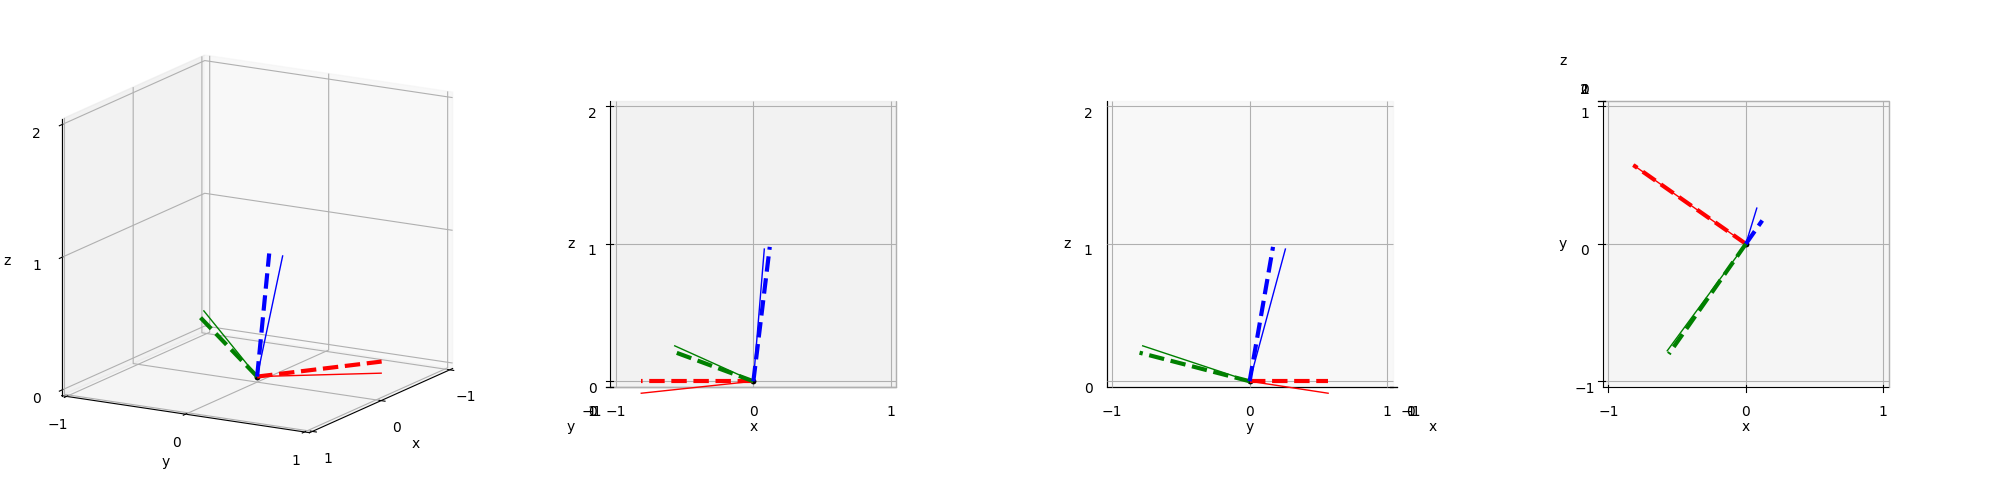

In [72]:
draw_results(T_sta, T_est)
# The solid line is for estimate
# The dashed line is for closest stable pose

### 2 Test pipeline with estimates from real experienment

#### 2.1 Insert Mold

In [73]:
data_all_instances = np.load("./11_23_image_dataset/insertmold.npz", allow_pickle=True)
print("npz file keys: ", list(data_all_instances.keys()))
print()

instance_data = data_all_instances['1'].item()
print("data keys: ", list(instance_data.keys()))
print()


# T_est_in_tag = np.array(instance_data['T_part_in_tag'])
# print("T_est_in_tag: \n", T_est_in_tag)
# print()

T_est_in_tagDown = np.array(instance_data['T_part_in_tag'])
print("T_est_in_tag: \n", T_est_in_tagDown)
print()

T_tagDown_in_cam = np.load("./11_23_image_dataset/T_tagboard_in_cam.npy")
T_tagUp_in_tagDown = np.eye(4)
T_tagUp_in_tagDown[:3, :3] = Rotation.from_euler('xyz', [180, 0, 0], degrees=True).as_matrix()
T_tagDown_in_tagUp = np.linalg.inv(T_tagUp_in_tagDown)
T_tagUp_in_cam = T_tagDown_in_cam @ T_tagUp_in_tagDown
T_est_in_tagUp = T_tagDown_in_tagUp @ T_est_in_tagDown
T_est_in_tag = T_est_in_tagUp

T_tag_in_cam = T_tagUp_in_cam

R_est_in_tag = T_est_in_tag[:3, :3]
euler_angles = Rotation.from_matrix(R_est_in_tag).as_euler('xyz', degrees=True)
print("euler_angles: ", euler_angles)

npz file keys:  ['0', '1', '2', '3', '4', '5']

data keys:  ['class', 'uv', 'score', 'image_128x128', 'T_part_in_cam', 'T_part_in_tag']

T_est_in_tag: 
 [[ 0.14470733 -0.97770514 -0.15215926  0.08222682]
 [-0.95392337 -0.17869915  0.24103281 -0.08688558]
 [-0.26284975  0.11026906 -0.95851486 -0.00624577]
 [ 0.          0.          0.          1.        ]]

euler_angles:  [ -6.56254726 -15.23922373  81.37416601]


In [74]:
# these two lists should be element-aligned. 
# i.e. alphas[i] should correspond to z_offsets[i]
alphas_insertmold = np.array([0, 12, -146, 156])
z_offsets_insertmold = np.array([0.0021, 0.0019, 0.0032, 0.0013])

stable_poses_R = construct_R_sta_list(alphas_insertmold)
print("Number of stable poses to consider: ", len(stable_poses_R))

Number of stable poses to consider:  1440


In [75]:
R_sta_in_tag = find_closest_stable_pose(stable_poses_R, T_est_in_tag[:3, :3])

def construct_T_from_R_sta_and_T_est(R_sta, T_est, alphas, z_offsets):
    alpha_sta = Rotation.from_matrix(R_sta).as_euler('xyz', degrees=True)[0]
    index = np.where(alphas == int(alpha_sta))[0]
    z_offset_sta = z_offsets[index]
    t_sta = np.array([T_est[0,3], T_est[1,3], z_offset_sta], dtype=object)
    T_sta = construct_T(R_sta, t_sta)
    return T_sta

T_sta_in_tag = construct_T_from_R_sta_and_T_est(R_sta_in_tag, T_est_in_tag, alphas_insertmold, z_offsets_insertmold)

print("Transformation Matrix for Estimated Pose:")
print(T_est_in_tag)
print("Euler angles for Estimated Pose:", Rotation.from_matrix(T_est_in_tag[:3, :3]).as_euler('xyz', degrees=True))
print()
print("Transformation Matrix for Stable Pose:")
print(T_sta_in_tag)
print("Euler angles for closest stable pose:", Rotation.from_matrix(T_sta_in_tag[:3, :3]).as_euler('xyz', degrees=True))

print()
print("Angular Difference: ", angular_R_diff(T_est_in_tag[:3, :3], T_sta_in_tag[:3, :3]), "degrees")

Transformation Matrix for Estimated Pose:
[[ 0.14470733 -0.97770514 -0.15215926  0.08222682]
 [ 0.95392337  0.17869915 -0.24103281  0.08688558]
 [ 0.26284975 -0.11026906  0.95851486  0.00624577]
 [ 0.          0.          0.          1.        ]]
Euler angles for Estimated Pose: [ -6.56254726 -15.23922373  81.37416601]

Transformation Matrix for Stable Pose:
[[ 0.17364818 -0.98480775  0.          0.08222682]
 [ 0.98480775  0.17364818  0.          0.08688558]
 [ 0.          0.          1.          0.0021    ]
 [ 0.          0.          0.          1.        ]]
Euler angles for closest stable pose: [ 0.  0. 80.]

Angular Difference:  16.568745504232147 degrees


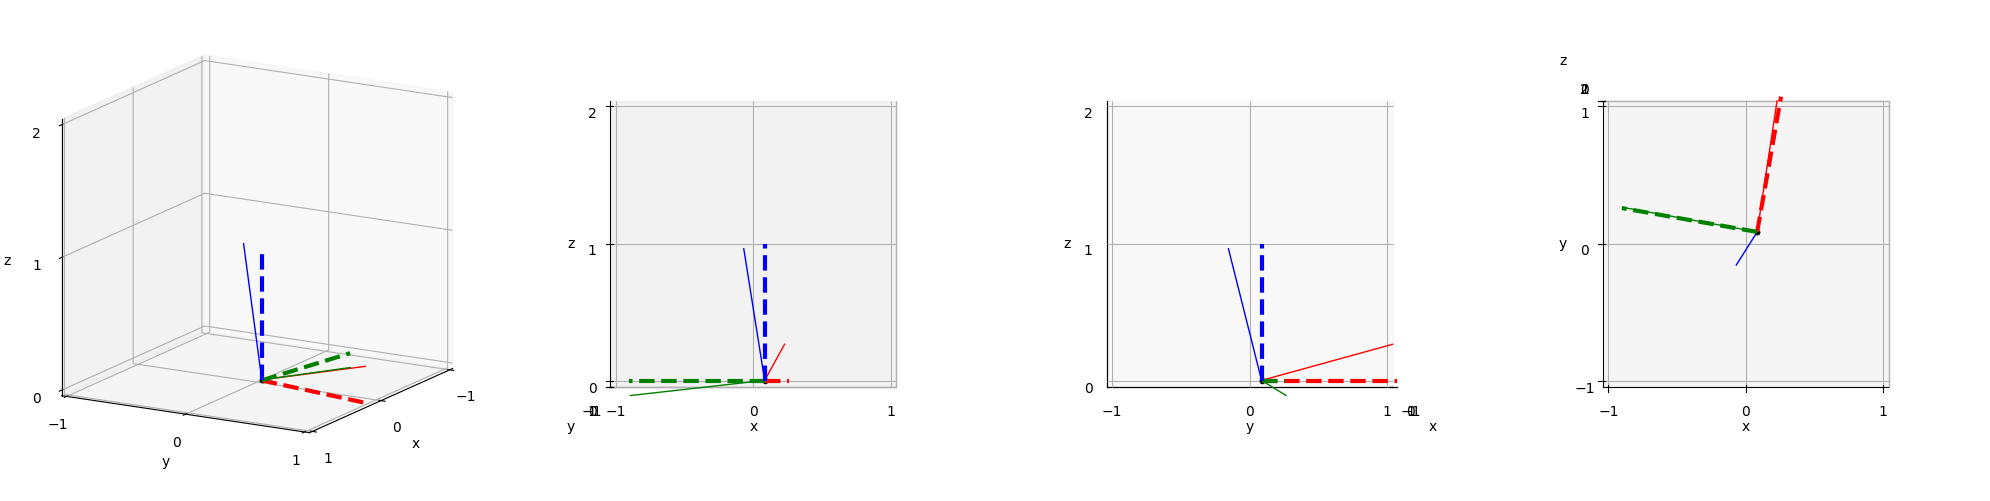

In [76]:
draw_results(T_sta_in_tag, T_est_in_tag, s=1)
# The solid line is for estimate
# The dashed line is for closest stable pose

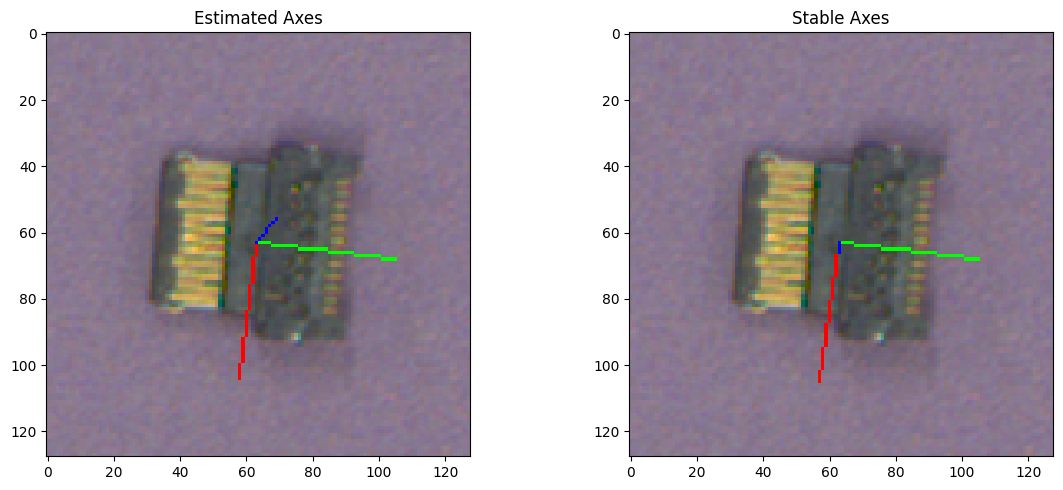

In [77]:
import cv2
def draw_axis(img, R, t, K, scale=0.006, dist=None):
    """
    Draw a 6dof axis (XYZ -> RGB) in the given rotation and translation
    :param img - rgb numpy array
    :R - Rotation matrix, 3x3
    :t - 3d translation vector, in meters (dtype must be float)
    :K - intrinsic calibration matrix , 3x3
    :scale - factor to control the axis lengths
    :dist - optional distortion coefficients, numpy array of length 4. If None distortion is ignored.
    """
    img = img.astype(np.float32)
    rotation_vec, _ = cv2.Rodrigues(R) #euler rotations
    dist = np.zeros(4, dtype=float) if dist is None else dist
    points = scale * np.float32([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0]]).reshape(-1, 3)
    axis_points, _ = cv2.projectPoints(points, rotation_vec, t, K, dist)
    
    axis_points = axis_points.astype(int)
    corner = tuple(axis_points[3].ravel())
    img = cv2.line(img, corner, tuple(axis_points[0].ravel()), (255, 0, 0), 1)
    # img = cv2.putText(img, "X", tuple(axis_points[0].ravel()), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 1)

    img = cv2.line(img, corner, tuple(axis_points[1].ravel()), (0, 255, 0), 1)
    # img = cv2.putText(img, "Y", tuple(axis_points[1].ravel()), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 1)

    img = cv2.line(img, corner, tuple(axis_points[2].ravel()), (0, 0, 255), 1)

    img = img.astype(np.uint8)
    return img

img = instance_data["image_128x128"]

T_est_in_cam = T_tag_in_cam @ T_est_in_tag
T_sta_in_cam = T_tag_in_cam @ T_sta_in_tag

R_est_in_cam = T_est_in_cam[:3, :3]
R_sta_in_cam = T_sta_in_cam[:3, :3]

# Define 3D coordinates of axes in the object frame
axes_object_frame = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

# Transform coordinates to camera frame
axes_est_in_cam = R_est_in_cam @ axes_object_frame.T
axes_sta_in_cam = R_sta_in_cam @ axes_object_frame.T

cam_u = 2694.112343
cam_v = 1669.169773

W, H = int(5472), int(3648)
crop_size = 128
# shift the uv from original camera uv to cropped image center
shifted_u = cam_u + (W//2 - instance_data['uv'][0]) - (W//2 - crop_size//2)
shifted_v = cam_v + (H//2 - instance_data['uv'][1]) - (H//2 - crop_size//2)

K = np.array([[10704.062350, 0, shifted_u],
            [0, 10727.438047, shifted_v],
            [0, 0, 1]])

# Plotting in two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot estimated axes in the first subplot
axes[0].imshow(draw_axis(img, T_est_in_cam[:3,:3], T_est_in_cam[:3, 3], K))  # Display the image
axes[0].set_title('Estimated Axes')

# Plot stable axes in the second subplot
axes[1].imshow(draw_axis(img, T_sta_in_cam[:3,:3], T_est_in_cam[:3, 3], K))  # Display the image
axes[1].set_title('Stable Axes')

plt.tight_layout()
plt.show()

In [78]:
T_tagDown_in_cam = np.load("./11_23_image_dataset/T_tagboard_in_cam.npy")
# convert the euler angles to rotation matrix
T_tagDown_in_cam_euler_angles = Rotation.from_matrix(T_tagDown_in_cam[:3,:3]).as_euler('xyz', degrees=True)
print("T_tagDown_in_cam_euler_angles: ", T_tagDown_in_cam_euler_angles)
print()

T_cam_in_base = np.load("./T_camera_in_base.npy")
# convert the euler angles to rotation matrix
R_cam_in_base = T_cam_in_base[:3, :3]
T_cam_in_base_euler_angles = Rotation.from_matrix(R_cam_in_base).as_euler('xyz', degrees=True)
print("T_cam_in_base_euler_angles: ", T_cam_in_base_euler_angles)
print()

T_tag_in_base = T_cam_in_base @ T_tag_in_cam
# convert the euler angles to rotation matrix
R_tag_in_base = T_tag_in_base[:3, :3]
T_tag_in_base_euler_angles = Rotation.from_matrix(R_tag_in_base).as_euler('xyz', degrees=True)
print("T_tag_in_base_euler_angles: ", T_tag_in_base_euler_angles)
print()

# Rotate T_tag_in_cam by 180 degrees around x axis
T_tagDown_in_cam = np.load("./11_23_image_dataset/T_tagboard_in_cam.npy") 
T_tagUp_in_tagDown = np.eye(4)
T_tagUp_in_tagDown[:3, :3] = Rotation.from_euler('xyz', [180, 0, 0], degrees=True).as_matrix()
T_tagUp_in_cam = T_tagDown_in_cam @ T_tagUp_in_tagDown
T_tagUp_in_cam_euler_angles = Rotation.from_matrix(T_tagUp_in_cam[:3, :3]).as_euler('xyz', degrees=True)
print("T_cam_in_tagUp_euler_angles: ", T_tagUp_in_cam_euler_angles)
print()

T_tagUp_in_base = T_cam_in_base @ T_tagUp_in_cam
T_tagUp_in_base_euler_angles = Rotation.from_matrix(T_tagUp_in_base[:3, :3]).as_euler('xyz', degrees=True)
print("T_tagUp_in_base_euler_angles == T_tag_in_base_euler_angles: ", T_tagUp_in_base_euler_angles)

T_tagDown_in_cam_euler_angles:  [ -2.76763526   3.13530027 177.8192468 ]

T_cam_in_base_euler_angles:  [-177.68850123   -0.32293987  177.91035292]

T_tag_in_base_euler_angles:  [-5.06772072 -2.72213831  0.21515727]

T_cam_in_tagUp_euler_angles:  [177.23236474   3.13530027 177.8192468 ]

T_tagUp_in_base_euler_angles == T_tag_in_base_euler_angles:  [-5.06772072 -2.72213831  0.21515727]


In [79]:
# print(T_est_in_tag)
# print(T_sta_in_tag)

T_est_in_base = T_tag_in_base @ T_est_in_tag
T_sta_in_base = T_tag_in_base @ T_sta_in_tag

print("Transformation Matrix for Estimated Pose:")
print(T_est_in_base)
print("Euler angles for Estimated Pose:", Rotation.from_matrix(T_est_in_base[:3, :3]).as_euler('xyz', degrees=True))
print()
print("Transformation Matrix for Stable Pose:")
print(T_sta_in_base)
print("Euler angles for closest stable pose:", Rotation.from_matrix(T_sta_in_base[:3, :3]).as_euler('xyz', degrees=True))

print()
print("Angular Difference: ", angular_R_diff(T_est_in_base[:3, :3], T_sta_in_base[:3, :3]), "degrees")

Transformation Matrix for Estimated Pose:
[[ 0.13245501 -0.97126076 -0.19775792 -0.60342666]
 [ 0.97391708  0.16461409 -0.15616571  0.00627286]
 [ 0.18423137 -0.17191489  0.96773141 -0.02079152]
 [ 0.          0.          0.          1.        ]]
Euler angles for Estimated Pose: [-10.07335187 -10.61632264  82.25515719]

Transformation Matrix for Stable Pose:
[[ 0.17389871 -0.98361061 -0.04763813 -0.60322916]
 [ 0.98161807  0.16927693  0.08815487  0.00590739]
 [-0.07864602 -0.06209247  0.994967   -0.02491643]
 [ 0.          0.          0.          1.        ]]
Euler angles for closest stable pose: [-3.57100153  4.5107436  79.95398576]

Angular Difference:  16.568746337645123 degrees


In [75]:
import torch
import random
import numpy as np
import os

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if using mutiple gpu
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(12)

random.seed(seed)
torch.rand(5)

tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904])